In this kernel, we will explore the complete workflow for the APTOS 2019 competition. We will go through:

1. Loading & Exploration: A quick overview of the dataset
2. Resize Images: We will resize both the training and test images to 224x224, so that it matches the ImageNet format.
3. Mixup & Data Generator: We show how to create a data generator that will perform random transformation to our datasets (flip vertically/horizontally, rotation, zooming). This will help our model generalize better to the data, since it is fairly small (only ~3000 images).
4. Quadratic Weighted Kappa: A thorough overview of the metric used for this competition, with an intuitive example. Check it out!
5. Model: We will use a DenseNet-121 pre-trained on ImageNet. We will finetune it using Adam for 15 epochs, and evaluate it on an unseen validation set.
6. Training & Evaluation: We take a look at the change in loss and QWK score through the epochs.

### Citations & Resources

* I had the idea of using mixup from [KeepLearning's ResNet50 baseline](https://www.kaggle.com/mathormad/aptos-resnet50-baseline). Since the implementation was in PyTorch, I instead used an [open-sourced keras implementation](https://github.com/yu4u/mixup-generator).
* The transfer learning procedure is mostly inspired from my [previous kernel for iWildCam](https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019). The workflow was however heavily modified since then.
* Used similar [method as Abhishek](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa) to find the optimal threshold.
* [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets) prompted me to try using Multilabel instead of multiclass classification, which slightly improved the kappa score.

In [1]:
import json
import math
import os
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121,VGG16
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import numpy
%matplotlib inline

Using TensorFlow backend.


# Loading & Exploration

In [2]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

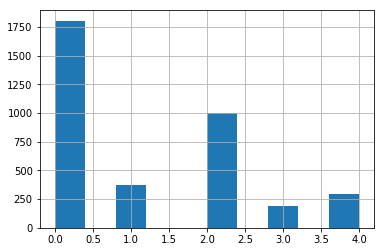

In [3]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

New Data Size: 7324 Old Size: 7324


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8122bcd898>]],
      dtype=object)

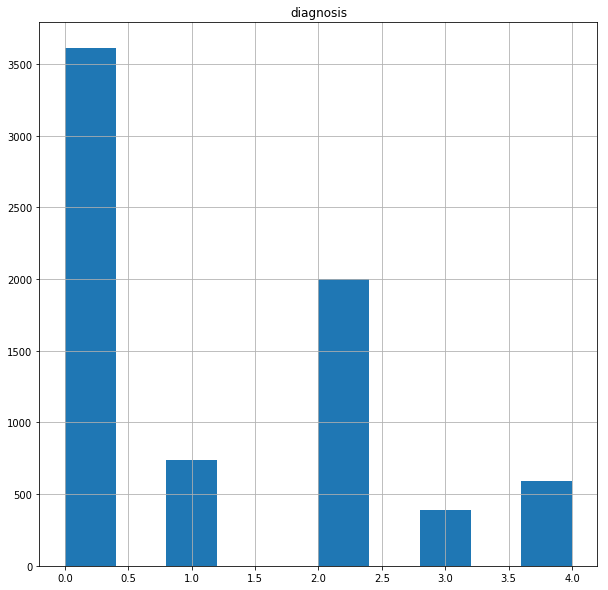

In [4]:
train_df = train_df.groupby(['diagnosis', 'id_code']).apply(lambda x: x.sample(2, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', train_df.shape[0])
train_df[['diagnosis', 'id_code']].hist(figsize = (10, 10))

### Displaying some Sample Images

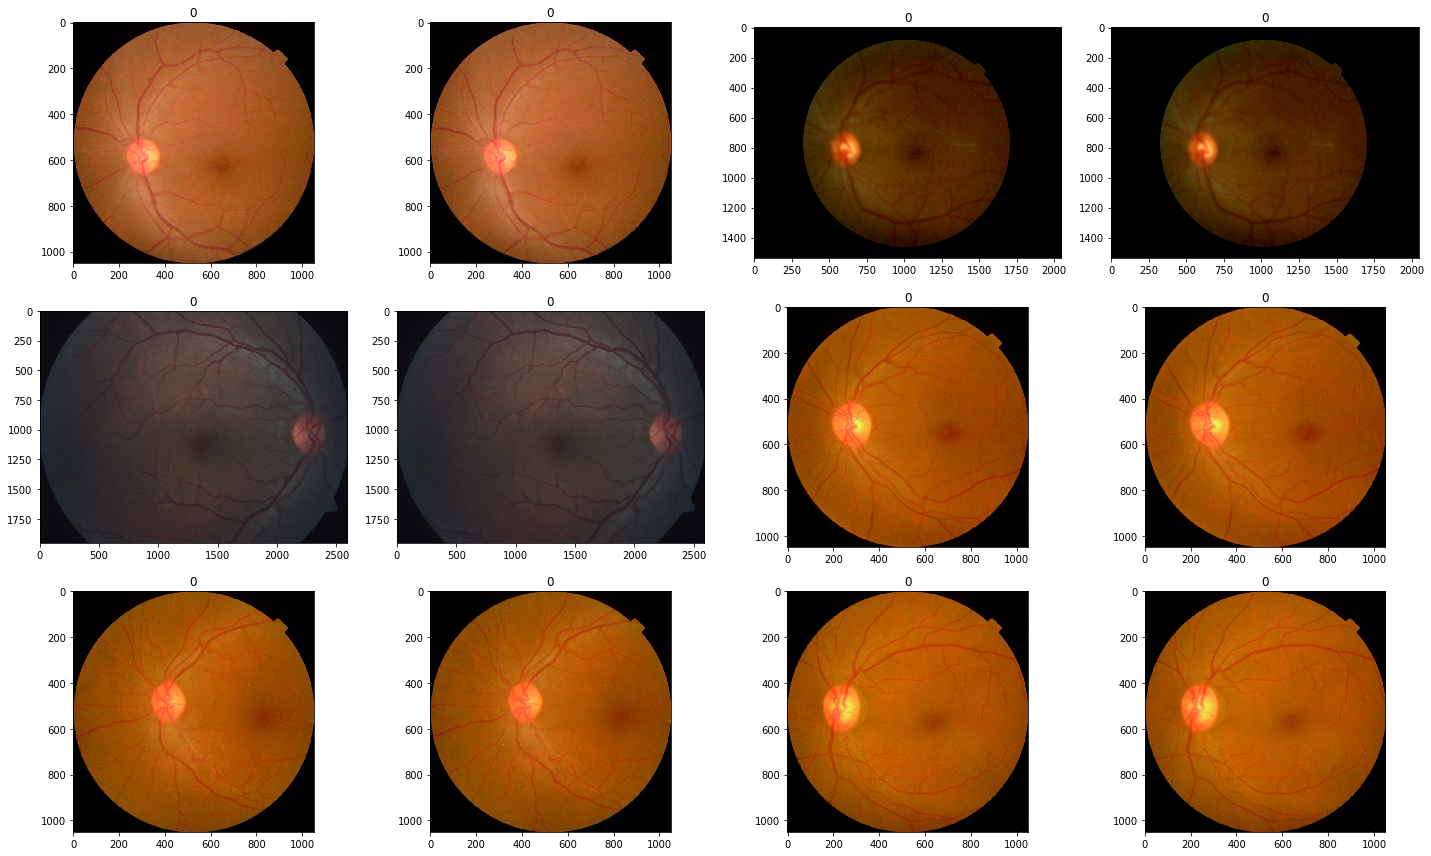

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Resize Images

We will resize the images to 224x224, then create a single numpy array to hold the data.

In [6]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    return im

In [7]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)
for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')

100%|██████████| 7324/7324 [16:31<00:00,  7.68it/s]


In [8]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [01:31<00:00, 21.07it/s]


In [9]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(7324, 224, 224, 3)
(7324, 5)
(1928, 224, 224, 3)


## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [10]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [3610  740 1998  386  590]
Multilabel version: [7324 3714 2974  976  590]


In [11]:
x_train.shape

(7324, 224, 224, 3)

In [12]:
y_train.shape

(7324, 5)

Now we can split it into a training and validation set.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_multi,test_size=0.15, random_state=2019)

# Mixup & Data Generator

In [14]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [15]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

# Quadratic Weighted Kappa

Quadratic Weighted Kappa (QWK, the greek letter $\kappa$), also known as Cohen's Kappa, is the official evaluation metric. For our kernel, we will use a custom callback to monitor the score, and plot it at the end.

### What is Cohen Kappa?

According to the [wikipedia article](https://en.wikipedia.org/wiki/Cohen%27s_kappa), we have
> The definition of $\kappa$ is:
> $$\kappa \equiv \frac{p_o - p_e}{1 - p_e}$$
> where $p_o$ is the relative observed agreement among raters (identical to accuracy), and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly seeing each category.

### How is it computed?

Let's take the example of a binary classification problem. Say we have:

In [16]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

We can construct the following table:

| true | pred | agreement      |
|------|------|----------------|
| 1    | 1    | true positive  |
| 0    | 0    | true negative  |
| 1    | 0    | false negative |
| 1    | 0    | false negative |
| 0    | 0    | true negative  |
| 1    | 1    | true positive  |


Then the "observed proportionate agreement" is calculated exactly the same way as accuracy:

$$
p_o = acc = \frac{tp + tn}{all} = {2 + 2}{6} = 0.66
$$

This can be confirmed using scikit-learn:

In [17]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

Additionally, we also need to compute `p_e`:

$$p_{yes} = \frac{tp + fp}{all} \frac{tp + fn}{all} = \frac{2}{6} \frac{4}{6} = 0.222$$

$$p_{no} = \frac{fn + tn}{all} \frac{fp + tn}{all} = \frac{4}{6} \frac{2}{6} = 0.222$$

$$p_{e} = p_{yes} + p_{no} = 0.222 + 0.222 = 0.444$$

Finally,

$$
\kappa = \frac{p_o - p_e}{1-p_e} = \frac{0.666 - 0.444}{1 - 0.444} = 0.4
$$

Let's verify with scikit-learn:

In [18]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

### What is the weighted kappa?

The wikipedia page offer a very concise explanation: 
> The weighted kappa allows disagreements to be weighted differently and is especially useful when **codes are ordered**. Three matrices are involved, the matrix of observed scores, the matrix of expected scores based on chance agreement, and the weight matrix. Weight matrix cells located on the diagonal (upper-left to bottom-right) represent agreement and thus contain zeros. Off-diagonal cells contain weights indicating the seriousness of that disagreement.

Simply put, if two scores disagree, then the penalty will depend on how far they are apart. That means that our score will be higher if (a) the real value is 4 but the model predicts a 3, and the score will be lower if (b) the model instead predicts a 0. This metric makes sense for this competition, since the labels 0-4 indicates how severe the illness is. Intuitively, a model that predicts a severe retinopathy (3) when it is in reality a proliferative retinopathy (4) is probably better than a model that predicts a mild retinopathy (1).

### Creating keras callback for QWK

In [19]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

![](http://)# Model: inception v3

In [20]:
conv_base = InceptionV3(weights='../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',input_shape=(224,224,3), include_top=False)

conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
#conv_base = VGG16(weights='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',#
               #   include_top=False, 
                #  input_shape=(224,224,3)
                 #)
#conv_base.summary()

In [22]:
#densenet = DenseNet121(
 #   weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
  #  include_top=False,
   # input_shape=(224,224,3)
#)

In [23]:
def build_model():
    model = Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [24]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


# Training & Evaluation

In [25]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/30
195/194 [==============================] - 87s 445ms/step - loss: 0.2510 - acc: 0.8978 - val_loss: 0.1459 - val_acc: 0.9394
val_kappa: 0.8311
Validation Kappa has improved. Saving model.
Epoch 2/30
195/194 [==============================] - 63s 324ms/step - loss: 0.1381 - acc: 0.9464 - val_loss: 0.1124 - val_acc: 0.9536
val_kappa: 0.9122
Validation Kappa has improved. Saving model.
Epoch 3/30
195/194 [==============================] - 63s 324ms/step - loss: 0.1121 - acc: 0.9556 - val_loss: 0.0963 - val_acc: 0.9612
val_kappa: 0.9123
Validation Kappa has improved. Saving model.
Epoch 4/30
195/194 [==============================] - 64s 327ms/step - loss: 0.0962 - acc: 0.9628 - val_loss: 0.1000 - val_acc: 0.9607
val_kappa: 0.9066
Epoch 5/30
195/194 [==============================] - 62s 320ms/step - loss: 0.0819 - acc: 0.9687 - val_loss: 0.0939 - val_acc: 0.9623
val_kappa: 0.9277
Validation Kappa has improved. Saving model.
Epoch 6/30
195/194 [==============================] - 6

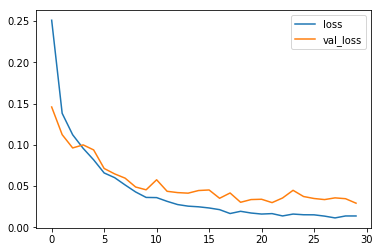

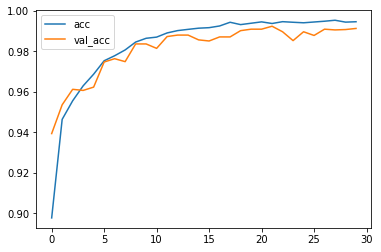

In [26]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

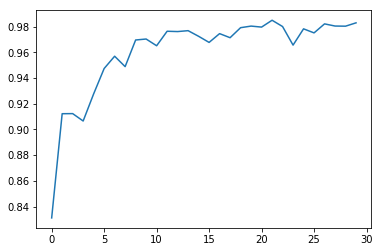

In [27]:
plt.plot(kappa_metrics.val_kappas)

## Find best threshold

In [28]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

## Submit

In [29]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)

In [30]:
test_df['diagnosis']

0       2
1       2
2       2
3       2
4       2
5       2
6       3
7       1
8       3
9       0
10      3
11      3
12      2
13      1
14      2
15      1
16      2
17      2
18      2
19      1
20      2
21      2
22      2
23      2
24      2
25      0
26      2
27      0
28      2
29      2
       ..
1898    0
1899    1
1900    2
1901    2
1902    2
1903    2
1904    1
1905    2
1906    1
1907    1
1908    2
1909    1
1910    2
1911    3
1912    2
1913    2
1914    2
1915    3
1916    3
1917    1
1918    4
1919    2
1920    2
1921    2
1922    2
1923    0
1924    2
1925    2
1926    4
1927    0
Name: diagnosis, Length: 1928, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b7b8cd470>]],
      dtype=object)

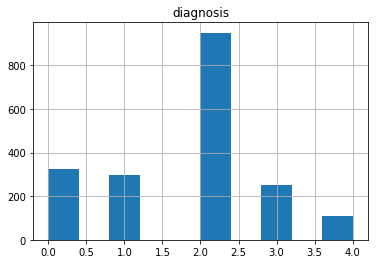

In [31]:
test_df.hist()